In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as pd
from pygem_eb.processing.plotting_fxns import *
from objectives import *
data_fp = '/home/claire/research/MB_data/Gulkana/Input_Gulkana_Glaciological_Data.csv'

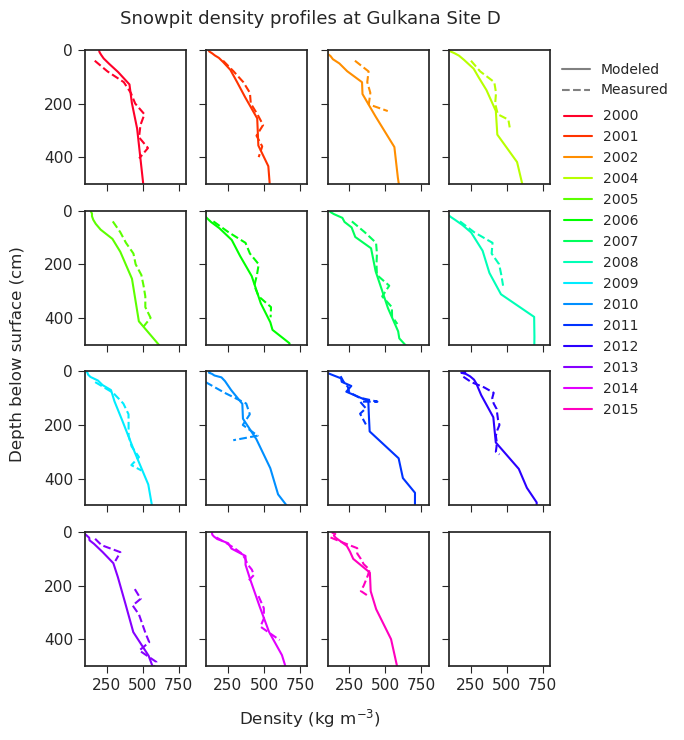

In [98]:
site = 'D'
ds,s,e =  getds(f'../Output/EB/Gulkana_2024_10_25_{site}_1.nc')
fp = '../MB_data/Point/gulkana/pitcore/'
import os
files = os.listdir(fp)
profiles = {'sbd':{},'density':{}}
for f in files:
    s = f.split('_')[-1].split('.')[0]
    if s == site and 'Pit' in f:
        if '_04' in f:
            year = int(f[8:12])
            df = pd.read_csv(fp + f)
            if len(df['sample_bottom_depth']) > 2:
                profiles['sbd'][year] = df['sample_bottom_depth'].to_numpy()
                density = df['sample_weight'] / df['volume'] * 1000
                profiles['density'][year] = density.to_numpy()

years = np.arange(2000,2025)
years = np.sort(list(set(years)&set(profiles['sbd'])))[:-1]
fig,axes = plt.subplots(4,4,figsize=(6,8),sharex=True,sharey=True)
axes = axes.flatten()
norm = mpl.colors.Normalize(vmin=years[0],vmax=years[-1])
cmap = mpl.colormaps.get_cmap('gist_rainbow')
for ax,year in zip(axes,years):
    dsyear = ds.sel(time=pd.to_datetime(f'{year}-04-20'))
    lheight = dsyear.layerheight.values*100
    ldepth = np.array([np.sum(lheight[:i+1])-(lheight[i]/2) for i in range(len(lheight))])
    ax.plot(dsyear['layerdensity'].values,ldepth,color=cmap(norm(year)))
    ax.plot(profiles['density'][year],profiles['sbd'][year],color=cmap(norm(year)),linestyle='--')
    axes[0].plot(np.nan,np.nan,label=year,color=cmap(norm(year)))
    if year == years[3]:
        ax.plot(np.nan,np.nan,label='Modeled',color='grey')
        ax.plot(np.nan,np.nan,label='Measured',linestyle='--',color='grey')
    ax.invert_yaxis()
    ax.set_ylim(500,0)
    ax.tick_params(length=5,labelsize=11)
    ax.set_xlim(100,800)
fig.supxlabel('Density (kg m$^{-3}$)',fontsize=12,y=0.03)
fig.supylabel('Depth below surface (cm)',fontsize=12,x=0)
axes[-1].tick_params(length=5,labelsize=11)
axes[0].legend(bbox_to_anchor=(5.6,0.65))
axes[3].legend(bbox_to_anchor=(2.3,1))
fig.suptitle(f'Snowpit density profiles at Gulkana Site {site}',fontsize=13,y=0.93)
# plt.show()
plt.savefig(f'../MB_data/Point/gulkana{site}_pits_modeled.png',dpi=200,bbox_inches='tight')

In [242]:
16.87771571939646 - 16.8854945030521

-0.007778783655641774

In [241]:
-0.007778783655641686+16.8854945030521-0.001256162240846237

16.876459557155613

In [238]:
16.876459557155613

16.876459557155613

site T
Internal acc: 0.096 m w.e.


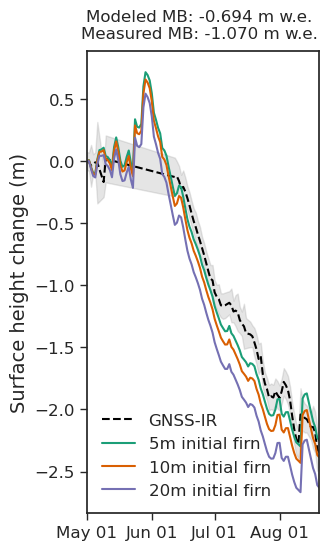

In [190]:
site = 'T'
id = 1
date = '10_25'
# for site in ['AU','ABB','B','D','T']:
for site in ['T']:
    ds,s,e =  getds(f'../Output/EB/Gulkana_{date}_2024{site}_{id}.nc')
    # ds2,s,e = getds('../Output/EB/Gulkana_2024_10_23_12.nc')
    # compare_runs([ds,ds2],[s,e],['without water','with water'],'albedo')
    print('site',site)
    fig,ax = cumulative_mass_balance(site,ds,plot=True)
    # ds = ds.sel(time=pd.date_range('2024-05-01 00:00',e,freq='h'))
    # previous = ds.dh.cumsum()-ds.dh.isel(time=0).values
    # previous = previous.sel(time=pd.date_range('2024-05-01 00:00',e))
    # ax.plot(previous.time,previous,label='Previous',color='goldenrod')
    # ax.legend(fontsize=12)
    # ax.set_title('Corrected dh accounting')
    # plt.savefig('../Output/EB/gulkanaT_dh_accounting.png',dpi=200,bbox_inches='tight')
    for id in [0,2]:
        ds,s,e =  getds(f'../Output/EB/Gulkana_{date}_2024{site}_{id}.nc')
        start = pd.to_datetime('2024-05-01 00:00')
        end = pd.to_datetime('2024-08-20 00:00')

        ds = ds.sel(time=pd.date_range(start,end,freq='h'))
        label = '20m initial firn' if id == 2 else '10m initial firn'
        j = 1 if id == 0 else 2
        fh = ds.dh.cumsum() - ds.dh.isel(time=0)
        # Accumulation area sites: need only dh above stake depth
        if site in ['D','T']:
            dh = []
            stake_depth = 9
            for hour in pd.date_range(start,end,freq='h'):
                ds_now = ds.sel(time=hour)
                lheight = ds_now.layerheight.values 
                ldepth = np.array([np.sum(lheight[:i+1])-(lheight[i]/2) for i in range(len(lheight))])
                layers = np.where(ldepth < stake_depth)[0]
                height_now = np.sum(lheight[layers])
                if hour == start:
                    height_before = height_now
                i = -1
                while np.abs(height_now - height_before) > 0.5:
                    height_now = np.sum(lheight[layers[:i]])
                    i -= 1
                    if len(layers[:i])<1:
                        break
                i = 1
                while np.abs(height_now - height_before) > 0.5:
                    height_now = np.sum(lheight[:layers[-1]+i])
                    i += 1
                    assert i < 20
                dh.append(height_now - height_before)
                height_before = height_now
                stake_depth += ds_now.dh.values
            ds['dh'].values = dh
        # Cumululative sum
        ds['dh'].values = ds.dh.cumsum().values - ds.dh.isel(time=0).values
        # Select data daily
        ds = ds.sel(time=pd.date_range(start,end)).dh
        ax.plot(ds.time,ds.values,label=label,color=plt.cm.Dark2(j))
    ax.legend(fontsize=12)
    fig.suptitle(ax.get_title()[14:],y=0.95)
    ax.set_title('')
    # plt.show()
    plt.savefig(f'../Output/EB/gulkana{site}_firn0_dh.png',dpi=150,bbox_inches='tight')
    # visualize_layers(ds,pd.date_range('2024-04-20 00:00','2024-08-20',freq='d'),['layerdensity','layertemp','layergrainsize'],ylim=(20))
    # fig,ax = simple_plot(ds,[s,e], [['melt','runoff','refreeze','accum']]) #[['meltenergy','SWnet','LWnet','sensible','latent'],['albedo'],['airtemp']])
    # ax[-1].set_xticks(pd.date_range(s,e,freq='MS'))
    # plt.show()
#     fig.suptitle(f'Site {site}'+'\n2x wind reduction and -1$^{\circ}$C',y=1) # -1.5$^{\circ}$C
#     plt.savefig(f'../Output/EB/10_24_site{site}_lowboth.png',dpi=150,bbox_inches='tight')
# # ds

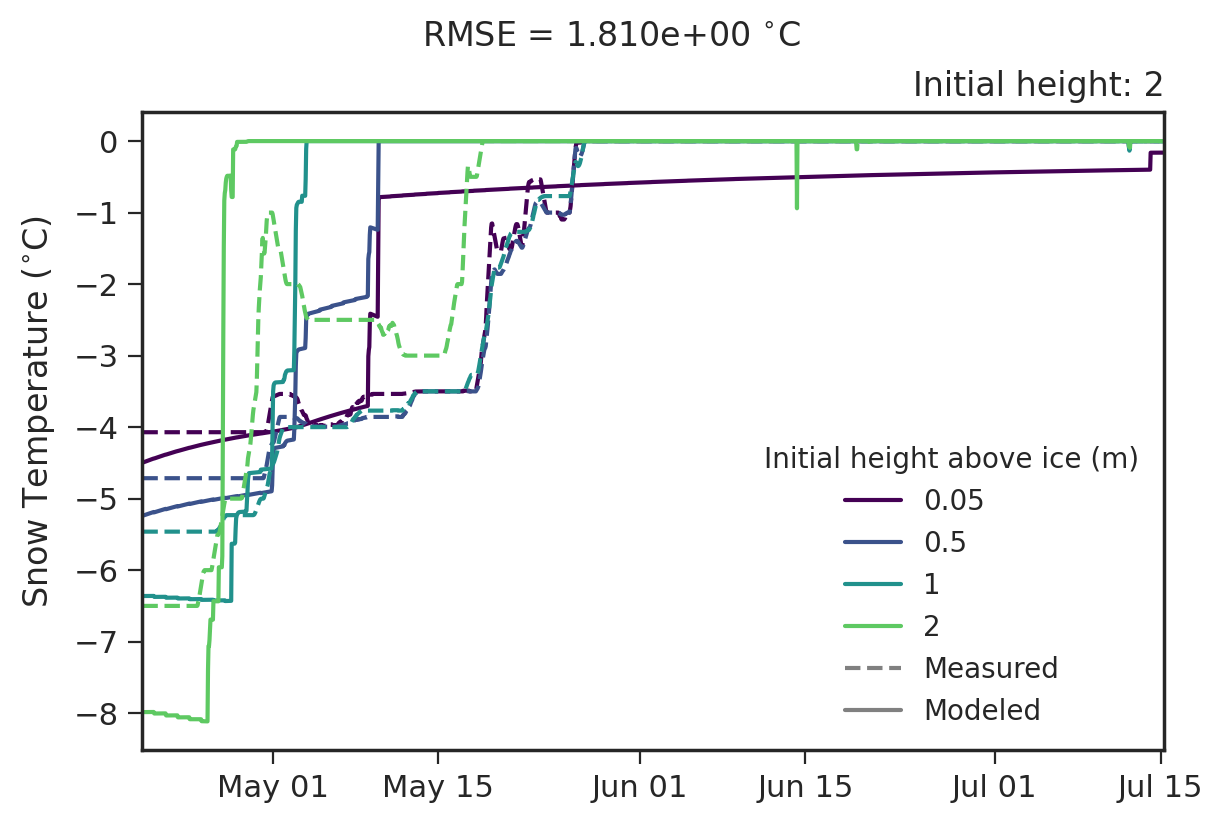

1.8099284073245785

In [249]:
site = 'B'
ds,s,e =  getds(f'../Output/EB/Gulkana_10_25_2024{site}_0.nc')
snow_temperature(site,ds,plot=True,plot_heights=[0.05,0.5,1,2])
# cumulative_mass_balance('T',ds,plot=True)
# visualize_layers(ds,pd.date_range('2024-04-21',e,freq='d'),['layertemp','layerdensity','layerrefreeze'],plot_ice=True) #,ylim=(150))

Compare albedo

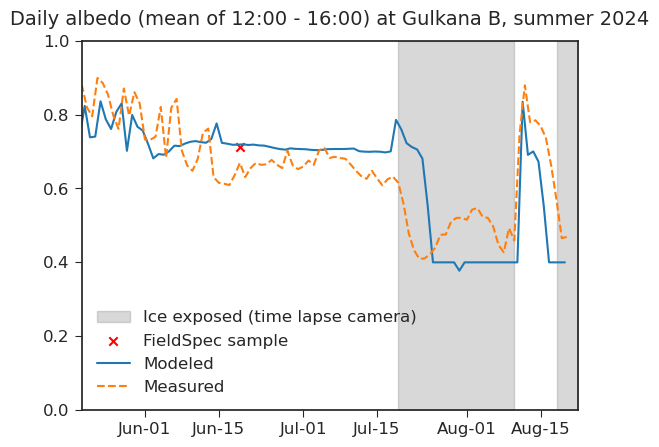

In [4]:
df = pd.read_csv('/home/claire/research/climate_data/AWS/Preprocessed/CLAWS_2024_wSWout.csv',index_col=0)
df.index = pd.to_datetime(df.index) # - pd.Timedelta(hours=8)
# df['albedo'] = df['SWout'] / df['SWin']
daily_albedo = []
dates = pd.date_range('2024-05-20','2024-08-22',freq='d')
for date in dates:
    start = pd.to_datetime(str(date.date())+' 12:00')
    end = pd.to_datetime(str(date.date())+' 16:00')
    # print(df.loc[start:end,'albedo'].values)
    daily_albedo.append(np.mean(df.loc[start:end,'albedo']))
y = np.arange(0,1.1,0.1)
fig,ax = plt.subplots()
ax.fill_betweenx(y,[pd.to_datetime('2024-07-19')],[pd.to_datetime('2024-08-10')],color='grey',alpha=0.3,label='Ice exposed (time lapse camera)')
ax.fill_betweenx(y,[pd.to_datetime('2024-08-18')],[pd.to_datetime('2024-08-22')],color='grey',alpha=0.3)
ax.scatter(pd.to_datetime('2024-06-19'),0.7123,marker='x',color='red',label='FieldSpec sample')
ax.set_xlim(dates[0],dates[-1])
ax.set_ylim(0,1)
ax.tick_params(labelsize=12)

ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b-%d'))
ax.set_title('Daily albedo (mean of 12:00 - 16:00) at Gulkana B, summer 2024',fontsize=14,y=1.02)
plt.tick_params(size=5)
dsp = ds.sel(time=pd.date_range('2024-04-20 14:00','2024-08-19 14:00'))
ax.plot(dsp.time,dsp['albedo'],label='Modeled')
ax.plot(dates,daily_albedo,label='Measured',linestyle='--')
# plt.savefig('/home/claire/research/climate_data/AWS/gulkana_albedo_2024.png',dpi=150,bbox_inches='tight')
ax.legend(fontsize=12)
plt.show()

Removing variables and compare dh resutl

In [4]:
# store = {}
# site='B'
# fp = '/home/claire/research/MB_data/Stakes/gulkanaB24_GNSSIR.csv'
# store['base'],_,_ = getds('../Output/EB/base_0.nc')
# fig,ax = cumulative_mass_balance(fp,store['base'],plot=True)
# fig.suptitle(f'Site B forced with all AWS data')
# model_melt = -store['base'].melt.sum().values + store['base'].accum.sum().values + store['base'].refreeze.sum().values
# df_stakes = pd.read_csv('../MB_data/Gulkana/Input_Gulkana_Glaciological_Data.csv',index_col=0)
# stake_melt = df_stakes.loc[df_stakes['site_name'] == site].loc[2024]
# stake_melt = stake_melt['ba'] - stake_melt['bw']
# ax.set_title(f'Modeled summer MB: {model_melt:.2f}\nMeasured summer MB: {stake_melt:.2f}')
# for var in ['LWin']: #['SWin','LWin','rh','sp','temp','wind']:
#     store['no'+var],_,_ = getds(f'../Output/EB/no{var}_0.nc')
#     fig,ax = cumulative_mass_balance(fp,store['no'+var],plot=True)
#     ax.set_title(f'Replaced AWS {var} with MERRA-2')

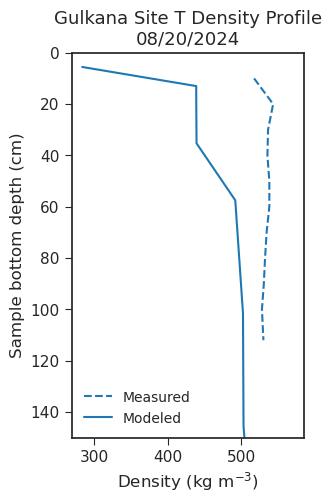

In [85]:
site = 'T'
ds,s,e =  getds(f'../Output/EB/Gulkana_{date}_2024{site}_0.nc')
profile = pd.read_csv('../MB_data/Gulkana/gulkanaT_2024pit.csv').astype(float)
dssel = ds.isel(time=-1)
lheight = dssel.layerheight.values
ldepth = np.array([np.sum(lheight[:i+1]) for i in range(len(dssel.layerheight))])
ldepth *= 100
fig,ax = plt.subplots(figsize=(3,5))
ax.plot(profile['density'],profile['depth'],linestyle='--',label='Measured')
ax.plot(dssel.layerdensity.values[:10],ldepth[:10],color=plt.cm.tab20(0),label='Modeled')
norm = mpl.colors.Normalize(vmin=2000,vmax=2016)
ax.legend()
ax.invert_yaxis()
ax.tick_params(length=5)
ax.set_ylim(150,0)
ax.set_xlabel('Density (kg m$^{-3}$)',fontsize=12)
ax.set_ylabel('Sample bottom depth (cm)',fontsize=12)
ax.tick_params(labelsize=11)
plt.title(f'Gulkana Site {site} Density Profile\n08/20/2024',fontsize=13)
# plt.show()
plt.savefig(f'../MB_data/Point/gulkana{site}_2024_pit_comparison.png',dpi=200,bbox_inches='tight')

In [16]:
# id = 2
# for site in ['AB','B','D','T']:
#     ds,startdate,enddate = getds(f'../Output/EB/Gulkana_2024_10_17_{site}_{id}.nc')
#     fp = f'/home/claire/research/MB_data/Stakes/gulkana{site}24_GNSSIR.csv'
#     if site != 'T':
#         fig,ax = seasonal_mass_balance(data_fp,ds,site,plot=True)
#         fig.suptitle(f'MERRA-2 inputs: site {site}',y=1.05)
#         # plt.show()
#         plt.savefig(f'../Output/EB/10_17/longrun_{site}_mb.png',dpi=200,bbox_inches='tight')
#     if site != 'D':
#         fig,ax = cumulative_mass_balance(fp,ds,plot=True)
#         fig.suptitle(f'Site {site} long run',y=0.98)
#         spring_date = df_stakes.loc[df_stakes['site_name'] == site].loc[2024,'spring_date']
#         spring_date = max(pd.to_datetime(spring_date),pd.to_datetime('2024-04-20'))
#         fall_date = df_stakes.loc[df_stakes['site_name'] == site].loc[2024,'fall_date']
#         fall_date = min(pd.to_datetime(fall_date),pd.to_datetime('2024-08-20'))
#         ds = ds.sel(time=pd.date_range(spring_date,fall_date,freq='h'))
#         cmb = ds.accum + ds.refreeze - ds.melt
#         model_melt = cmb.sum().values
#         df_stakes = pd.read_csv(data_fp,index_col=0)
#         stake_melt = df_stakes.loc[df_stakes['site_name'] == site].loc[2024]
#         stake_melt = stake_melt['ba'] - stake_melt['bw']
#         ax.set_title(f'Modeled summer MB: {model_melt:.2f}\nMeasured summer MB: {stake_melt:.2f}')
#         # plt.show()
#         plt.savefig(f'../Output/EB/10_17/longrun_{site}_dh.png',dpi=200,bbox_inches='tight')

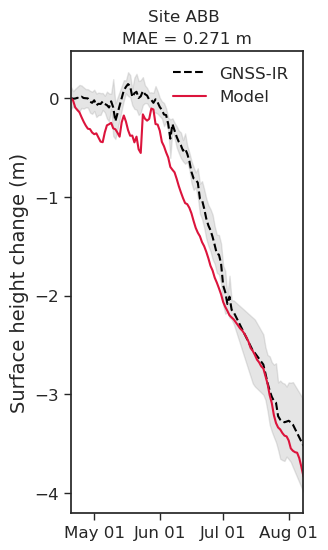

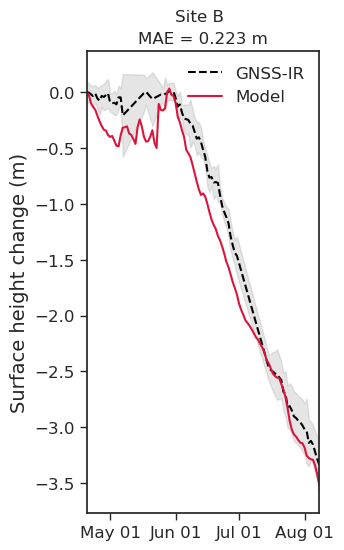

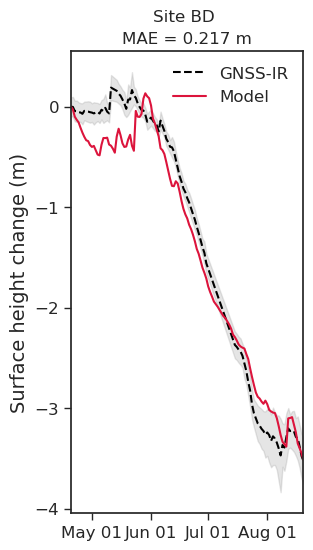

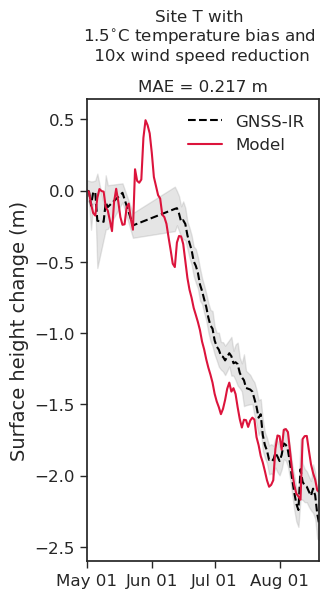

In [32]:
id = 9
for site in ['ABB','B','BD','T']:
# for site in ['T']:
    ds,startdate,enddate = getds(f'../Output/EB/Gulkana_2024_10_23_2024{site}_{id}.nc')
    fp = f'/home/claire/research/MB_data/Stakes/gulkana{site}24_GNSSIR.csv'
    fig,ax = cumulative_mass_balance(fp,ds,plot=True)
    fig.suptitle(f'Site {site}',y=0.95)
    if site == 'T':
        fig.suptitle(f'Site {site}'+' with\n1.5$^{\circ}$C temperature bias and\n 10x wind speed reduction',y=1.03)
    
    if site not in ['ABB','BD']:
        df_stakes = pd.read_csv('../MB_data/Gulkana/Input_Gulkana_Glaciological_Data.csv',index_col=0)
        stake_melt = df_stakes.loc[df_stakes['site_name'] == site].loc[2024]
        spring_date = df_stakes.loc[df_stakes['site_name'] == site].loc[2024,'spring_date']
        spring_date = max(pd.to_datetime(spring_date),pd.to_datetime('2024-04-20'))
        fall_date = df_stakes.loc[df_stakes['site_name'] == site].loc[2024,'fall_date']
        fall_date = min(pd.to_datetime(fall_date),pd.to_datetime('2024-08-19'))
        ds = ds.sel(time=pd.date_range(spring_date,fall_date,freq='h'))
        stake_melt = stake_melt['ba'] - stake_melt['bw']
        model_cmb = ds.accum + ds.refreeze - ds.melt
        model_melt = model_cmb.sum().values
        # ax.set_title(f'Modeled summer MB: {model_melt:.2f}\nMeasured summer MB: {stake_melt:.2f}')
    # plt.show()
    plt.savefig(f'/home/claire/research/Output/EB/gulkana{site}_10_23.png',dpi=180,bbox_inches='tight')

(<Figure size 500x170 with 2 Axes>, <Axes: ylabel='Density (kg m$^{-3}$)'>)

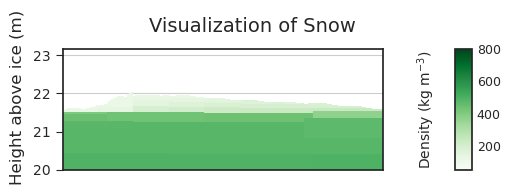

In [106]:
visualize_layers(ds,pd.date_range('2024-08-10','2024-08-19 00:00',freq='h'),['layerdensity'],ylim=(20))

In [ ]:
id = 8
site = 'B'
import os
# ds,startdate,enddate = getds(f'../Output/EB/Gulkana_2024_10_17_{id}.nc')
depths = np.arange(10,500,20)
fps = os.listdir('../MB_data/Point/gulkana/pitcore/')
fig,ax = plt.subplots(figsize=(3,5))
    all = pd.DataFrame(np.zeros(len(depths)),index=depths)
    for year in np.arange(2000,2017):
        for fp in fps:
            if str(year) in fp and f'_{site}' in fp:
                if '04' in fp or '05' in fp:
                    fp_read = fp
        if str(year) not in fp_read:
            # print('skipping',year)
            continue
        df = pd.read_csv(f'../MB_data/Point/gulkana/pitcore/'+fp_read)
        if year not in [2002,2012]:
            df['density'] = df['sample_weight'] / df['volume'] * 1000
            df['sample_depth'] = df['sample_bottom_depth'] - 0.05
            density_interp = np.interp(depths,df['sample_depth'].values,df['density'].values)
            all[f'density_{year}'] = density_interp
            sample_date = fp_read[8:18].replace('_','-')
            # ax.plot(df['density'], df['sample_bottom_depth'] /100 ,label='Pit')
        # profile = ds.sel(time=pd.to_datetime(f'{sample_date} 14:00'))
        # snow_idx = np.where(profile['layerdensity'] < 800)[0]
        # snow_density = profile.isel(layer=snow_idx).layerdensity.values
        # snow_heights = profile.isel(layer=snow_idx).layerheight.values
        # snow_depths = np.array([np.sum(snow_heights[:i+1])-(snow_heights[i]/2) for i in range(len(snow_heights))])
        # ax.plot(snow_density,snow_depths,label='Model')
        ax.invert_yaxis()
        
        ax.tick_params(length=5,labelsize=11)
        ax.set_ylabel('Depth below surface (m)',fontsize=12)
        ax.set_xlabel('Snow density (kg m$^{-3}$)',fontsize=12)
# plt.title(f'Snow density comparison on {sample_date}\nGulkana long run, c5 = 0.025')
plt.show()

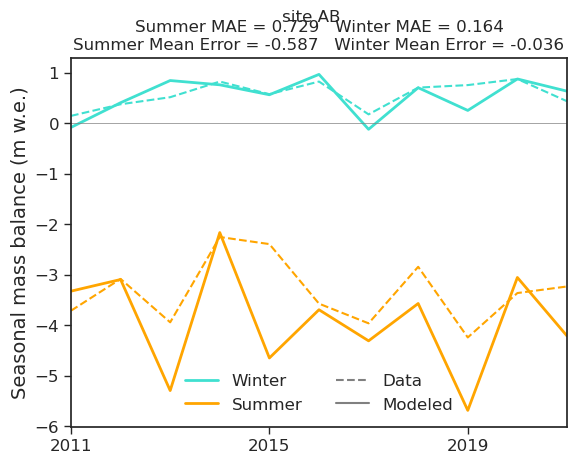

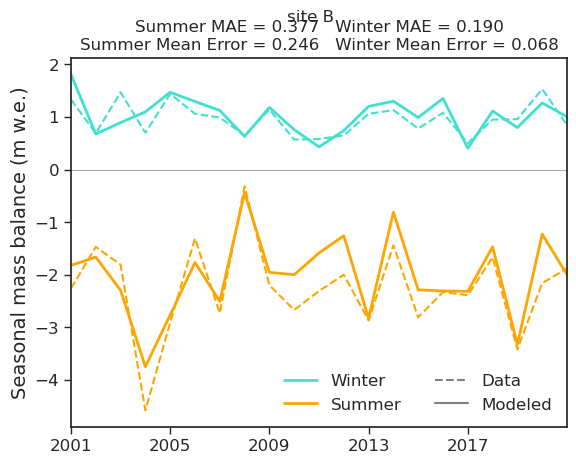

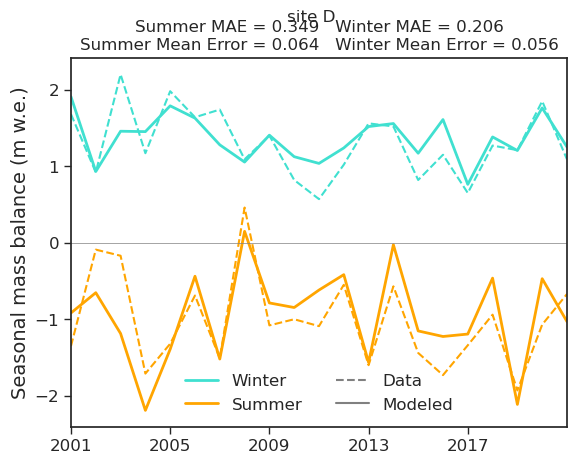

In [36]:
id =0
for site in ['AB','B','D']:
# for site in ['B']:
    ds,startdate,enddate = getds(f'../Output/EB/Gulkana_2024_10_21_{site}_{id}.nc')
    fig,ax = seasonal_mass_balance(data_fp,ds,site=site,plot=True)
    fig.suptitle(f'site {site}')

In [2]:
# FIND BEST RUN IN A SET
date = '10_18'
path_out = f'/home/claire/research/Output/calibration/{date}_0/'
sites= ['AB','B','D']
# fn = f'kw{kw}_ksnow{k_snow}_aice{a_ice}_site{site}_0.nc'
dsdict = {'AB':[],'B':[],'D':[]}
outdict = {'AB':[],'B':[],'D':[]}
for i in range(85):
    fn = f'calibration_{date}_run{i}_0.nc'
    try:
        ds,startdate,enddate = getds(path_out+fn)
    except:
        print(fn,'doesnt exist')
        continue
    site = ds.attrs['site']
    winter,summer = seasonal_mass_balance(data_fp,ds,site)
    dsdict[site].append(ds)
    # if i % 5 == 0:
    #     print(ds.attrs[param])
    # outdict[site].append(np.mean([winter,summer]))
    outdict[site].append(summer)
    # print(ds.attrs['k_snow'],winter,summer,np.mean([winter,summer]))
best = {}
for site in sites:
    best[site] = dsdict[site][np.argmin(outdict[site])]
    print(site,np.argmin(outdict[site]))
    # simple_plot(ds,['2004-04-20','2004-10-20'],[['albedo']],res='d')

AB 27
B 25
D 23


In [6]:
result_df = pd.DataFrame(data=np.zeros((len(sites),3)),columns=sites,index=['kp','kw','a_ice'])
for site in sites:
    ds = best[site]
    result_df.loc['kp',site] = float(ds.attrs['kp'])
    if site == 'D':
        result_df.loc['kw',site] = 2 #float(ds.attrs['kw'])
        result_df.loc['a_ice',site] = 0.4
    else:
        result_df.loc['a_ice',site] = float(ds.attrs['a_ice'])
        result_df.loc['kw',site] = 3
# result_df.to_csv(f'/home/claire/research/Gulkana_params_{date}_HIGHWIND.csv',sep=',')
print(result_df)

         AB    B    D
kp     3.20  3.2  3.2
kw     3.00  3.0  2.0
a_ice  0.25  0.4  0.4


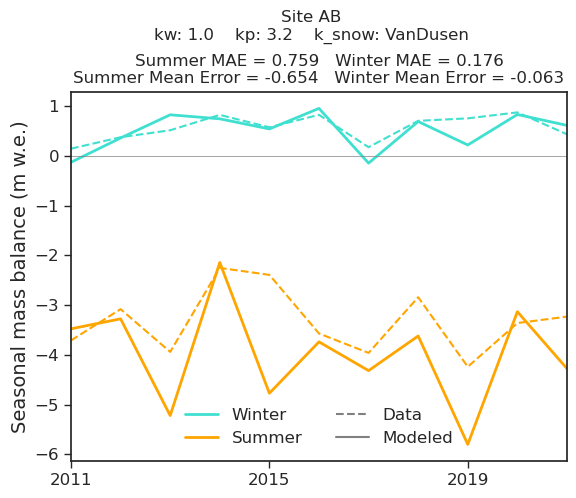

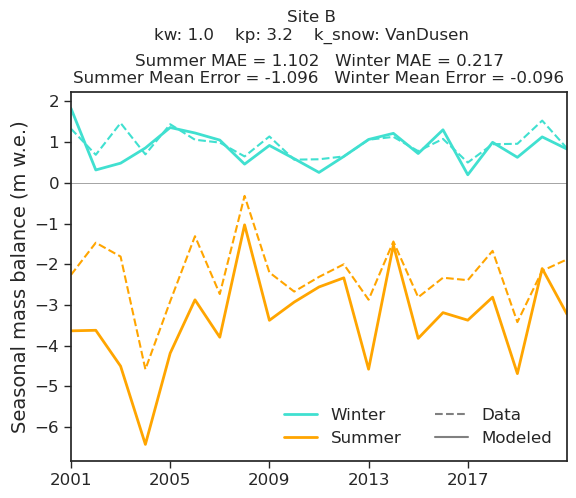

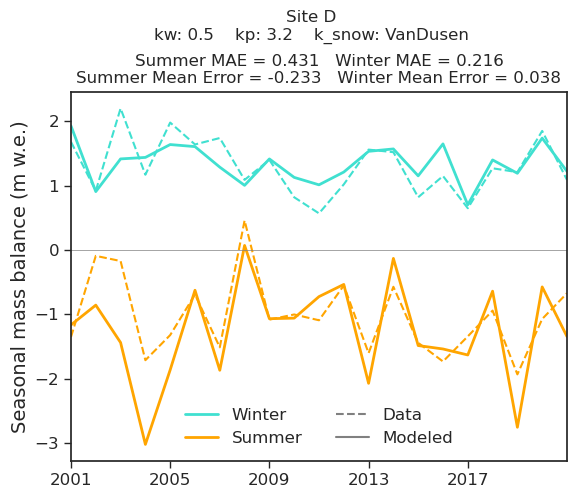

In [3]:
for site in sites:
    # ds = best[site]
    ds = dsdict[site][-1]
    # ds = xr.open_dataset(f'/home/claire/research/Output/EB/Gulkana_10_09_paramset_{site}_0.nc')
    param = 'kw' #if site == 'D' else 'a_ice'
    k_snow = ds.attrs['k_snow']
    kw = ds.attrs['kw']
    a_ice = ds.attrs['a_ice']
    kp = ds.attrs['kp']
    # kp = result_df.loc['kp',site]
    # kw = result_df.loc['kw',site]
    # a_ice = result_df.loc['a_ice',site]
    param_value = kw if param == 'kw' else a_ice # float(ds.attrs[param])
    fig,ax = seasonal_mass_balance(data_fp,ds,site,plot=True)
    fig.suptitle(f'Site {site}\n{param}: {param_value}    kp: {kp}    k_snow: {k_snow}',y=1.05)
    # plt.savefig(f'/home/claire/research/Output/calibration/{date}_paramsMERRA2_{site}.png',dpi=200,bbox_inches='tight')

In [11]:
var = 'wind'
ds_AWS = xr.open_dataset('/home/claire/research/Output/EB/Gulkana_2024_10_08_1_climate.nc')
ds_MERRA2 = xr.open_dataset('/home/claire/research/Output/EB/Gulkana_2024_10_08_0_climate.nc')
ds3 =  xr.open_dataset('/home/claire/research/Output/EB/Gulkana_2024_10_08_climate.nc')
# ds4 = ds3['temp'] *m+b
ds_AWS = ds_AWS[var].resample(time='MS').mean()
ds_MERRA2 = ds_MERRA2[var].resample(time='MS').mean()
ds3 = ds3[var].resample(time='MS').mean()
# ds4 = ds4.resample(time='MS').mean()

fig,axes = plt.subplots(1,2,figsize=(8,2.5),width_ratios=(2,1),gridspec_kw={'wspace':0.35})
axes[1].scatter(ds_AWS.values,ds3.values,color='red')
axes[1].set_ylabel('MERRA-2',fontsize=12)
axes[1].set_xlabel('AWS',fontsize=12)
valmin = np.min([ds_AWS.values,ds3.values])
# valmax = np.max([ds_AWS.values,ds3.values])
valmax = 7
axes[1].plot([valmin,valmax],[valmin,valmax],'k--')
axes[1].set_ylim(valmin,valmax)
axes[1].set_xlim(valmin,valmax)

# axes[2].scatter(ds_AWS.values,ds_MERRA2.values,label='MERRA-2',color='red')
# axes[2].set_ylabel('MERRA-2, Corrected',fontsize=12)
# axes[2].set_xlabel('AWS',fontsize=12)
# valmin = np.min([ds_AWS.values,ds_MERRA2.values])
# valmax = np.max([ds_AWS.values,ds_MERRA2.values])
# axes[2].plot([valmin,valmax],[valmin,valmax],'k--')
axes[1].set_ylim(1,6)
axes[1].set_xlim(1,6)
axes[1].set_xticks(np.arange(1,7))
axes[1].set_yticks(np.arange(1,7))
ax = axes[0]
dtfm = mpl.dates.DateFormatter('%Y')
ax.plot(ds_AWS.time,ds_AWS.values,label='AWS',color=mpl.cm.tab10(1))
ax.plot(ds3.time,ds3.values,label='MERRA-2',color=mpl.cm.tab10(2),linestyle=':')
# ax.plot(ds_MERRA2.time,ds4.values,label='MERRA-2 (corrected)',color=mpl.cm.tab10(0))
ax.set_ylim(1,6)
ax.set_yticks(np.arange(1,7))
ax.set_ylabel('Air temperature ($^{\circ}$C)',fontsize=12)
start = pd.to_datetime('2009-12-31 00:00')
# ax.set_ylabel('Wind speed (m/s)',fontsize=12)
end = pd.to_datetime('2020-01-01')
ax.set_xlim(start,end)
ax.xaxis.set_major_formatter(dtfm)
ax.set_xticks(pd.date_range(start,end,freq='24MS'))
ax.legend(facecolor='white',edgecolor='none',loc='upper left')
for ax in axes:
    ax.tick_params(length=5)
# plt.show()
plt.savefig('/home/claire/research/climate_data/MERRA2_AWS_NEWWIND.png',bbox_inches='tight',dpi=250)

0.7280142198171007 2.2339880865065864


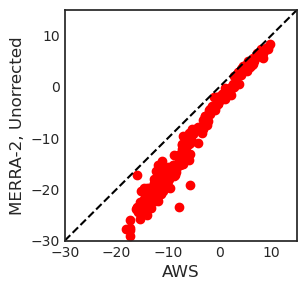

In [4]:
threshold = 15
aws = ds_AWS.values[ds3.values < threshold]
merra = ds3.values[ds3.values < threshold]

# m,_,_,_ = np.linalg.lstsq(merra[:, np.newaxis],aws,rcond=None)
# b = [0]
m,b = np.polyfit(merra,aws,1)
plt.figure(figsize=(3,3))
plt.scatter(ds_AWS.values,ds3.values,color='red')
plt.xlabel('AWS',fontsize=12)
plt.ylabel('MERRA-2, Unorrected',fontsize=12)
# plt.scatter(aws,merra*m+b,color='red')
# plt.scatter(ds_AWS.values[ds3.values >= threshold],ds3.values[ds3.values >= threshold],color='red')
minx = -30
maxx = 20 #np.max(merra)
# plt.plot([minx,maxx],[minx*m[0]+b[0],maxx*m[0]+b[0]],'k')
plt.plot([minx,maxx],[minx,maxx],'k--')
plt.xlim(-30,15)
plt.ylim(-30,15)
# plt.show()
plt.savefig('/home/claire/research/climate_data/uncorrected_temp.png',dpi=200,bbox_inches='tight')
print(m,b)

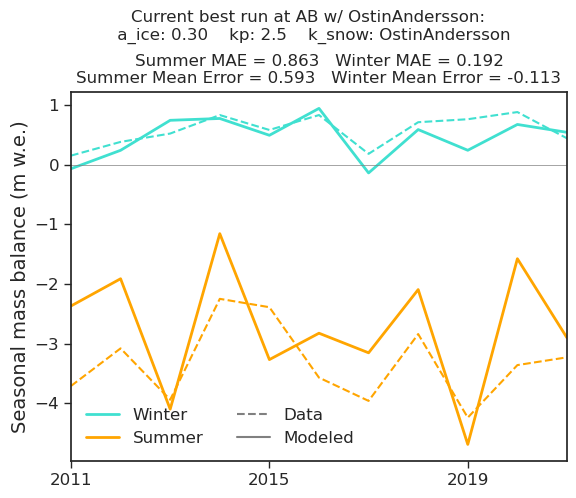

In [45]:
k_snow = ds.attrs['k_snow']
kw = ds.attrs['kw']
a_ice = ds.attrs['a_ice']
kp = ds.attrs['kp']
param_value = float(ds.attrs[param])
fig,ax = seasonal_mass_balance(data_fp,ds,site,plot=True)
fig.suptitle(f'Current best run at {site}: \n {param}: {param_value:.2f}    kp: {kp}    k_snow: {k_snow}',y=1.05)
# plt.show()
# plt.savefig(f'/home/claire/research/Output/calibration/10_05_0/best_{site}.png',dpi=200,bbox_inches='tight')

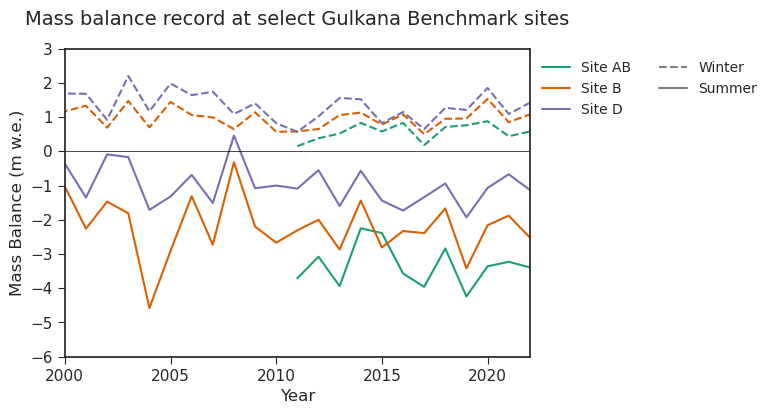

In [42]:
df = pd.read_csv(data_fp)
df['bs'] = df['ba'] - df['bw']
colors = mpl.cm.Dark2
plt.figure(figsize=(6,4))
for i,site in enumerate(['AB','B','D']):
    c = colors(i)
    site_df = df[df['site_name'] == site]
    plt.plot(site_df['Year'],site_df['bw'],linestyle='--',color=c)
    plt.plot(site_df['Year'],site_df['bs'],color=c,label=f'Site {site}')
plt.plot(np.nan,np.nan,linestyle='--',color='gray',label='Winter')
plt.plot(np.nan,np.nan,color='gray',label='Summer')
plt.axhline(0,color='black',linewidth=0.5)
plt.legend(ncols=2,bbox_to_anchor=(1,1))
plt.xlim(2000,2022)
plt.ylim(-6,3)
plt.xticks(np.arange(2000,2023,5))
plt.tick_params(size=5,labelsize=11)
plt.xlabel('Year',fontsize=12)
plt.ylabel('Mass Balance (m w.e.)',fontsize=12)
plt.title('Mass balance record at select Gulkana Benchmark sites',fontsize=14,y=1.05)
plt.savefig('/home/claire/research/MB_data/three_sites_legend.png',dpi=300,bbox_inches='tight')

In [234]:
path_out = '/home/claire/research/Output/calibration/09_24/'

# Parameter sets
aa = [0.2,0.4,0.6]
ww = [0.25,0.5,0.75,1]
kk = ['Sturm','Douville','Jansson'] #,'OstinAndersson','VanDusen']
params_dict = {'kw':ww,'k_snow':kk,'a_ice':aa} # 'kw':ww,

# Get the lengths of each parameter list for the result array shape
shape = [len(v) for v in params_dict.values()]

# Initialize result arrays with a dimension for site (3 sites + 1 for the average)
winter_result = np.ones([4] + shape)
summer_result = np.ones([4] + shape)

# Initialize lists for storing the parameters
params_list = {key: [] for key in params_dict}

# Generate combinations of all parameters
all_combos = itertools.product(*params_dict.values())
for idx, param_values in enumerate(all_combos):
    # Unpack indices
    indices = np.unravel_index(idx, shape)

    # Store parameter set
    for param_name, param_value in zip(params_dict.keys(), param_values):
        params_list[param_name].append(param_value)
    
    # Iterate over sites
    for s, site in enumerate(['AB', 'B', 'D']):
        kw = 0.25 if site == 'D' else 1
        fn = f'kw{kw}_'

        # fn = ''
        for param_name, param_value in zip(params_dict.keys(), param_values):
            fn += param_name.replace('_','')+str(param_value)+'_'
        fn += f'site{site}_0.nc'

        try:
            ds, startdate, enddate = getds(path_out + fn)
            winter, summer = seasonal_mass_balance(data_fp, ds, site=site, method='MAE')
        except:
            winter, summer = (np.nan, np.nan)
            print(fn + ' does not exist')
        
        # Store results in the corresponding array
        winter_result[s][indices] = winter
        summer_result[s][indices] = summer

    # Compute site averages and store in the last index (3rd index in the result arrays)
    winter_result[3][indices] = np.mean(winter_result[:3,*indices])
    summer_result[3][indices] = np.mean(summer_result[:3,*indices])

In [235]:
best = {'winter': {key: [] for key in params_dict}, 
        'summer': {key: [] for key in params_dict}}

if summer_result.shape == (4,4,3,3):
    print('When including kw as a parameter:')
elif summer_result.shape == (4,3,3):
    print('When setting kw = 0.25 at site D, 1 elsewhere:')
for site in ['mean','AB','B','D','mean']:
    idx = np.where(np.array(['AB','B','D','mean']) == site)[0]
    best_winter = np.argmin(winter_result[idx])
    best_summer = np.argmin(summer_result[idx])
    for key in params_dict:
        best['winter'][key] = params_list[key][best_winter]
        best['summer'][key] = params_list[key][best_summer]
    if site == 'mean':
        print('Best winter parameter set overall:',best['winter'])
        print('Best summer parameter set overall:',best['summer'])
        print()
    else:
        print(f'Best winter parameter set at site {site}:',best['winter'])
        print(f'Best summer parameter set at site {site}:',best['summer'])

When setting kw = 0.25 at site D, 1 elsewhere:
Best winter parameter set overall: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set overall: {'k_snow': 'Jansson', 'a_ice': 0.6}

Best winter parameter set at site AB: {'k_snow': 'Jansson', 'a_ice': 0.4}
Best summer parameter set at site AB: {'k_snow': 'Jansson', 'a_ice': 0.2}
Best winter parameter set at site B: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set at site B: {'k_snow': 'Jansson', 'a_ice': 0.6}
Best winter parameter set at site D: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set at site D: {'k_snow': 'Sturm', 'a_ice': 0.2}
Best winter parameter set overall: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set overall: {'k_snow': 'Jansson', 'a_ice': 0.6}



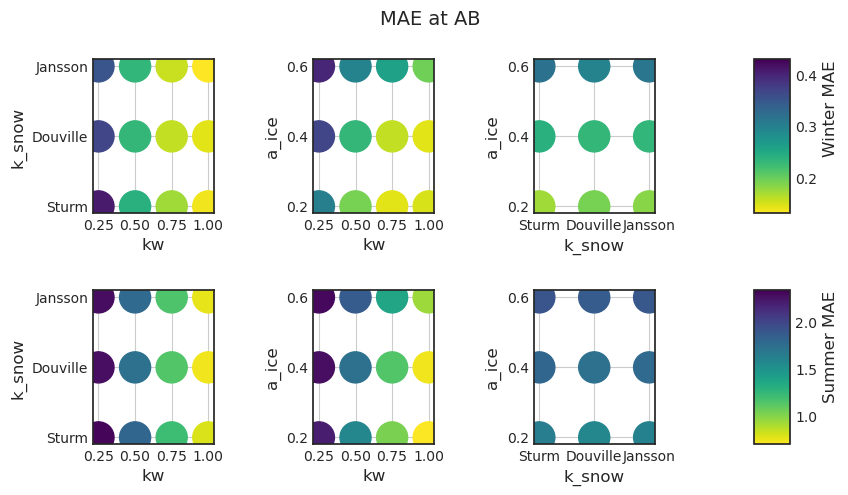

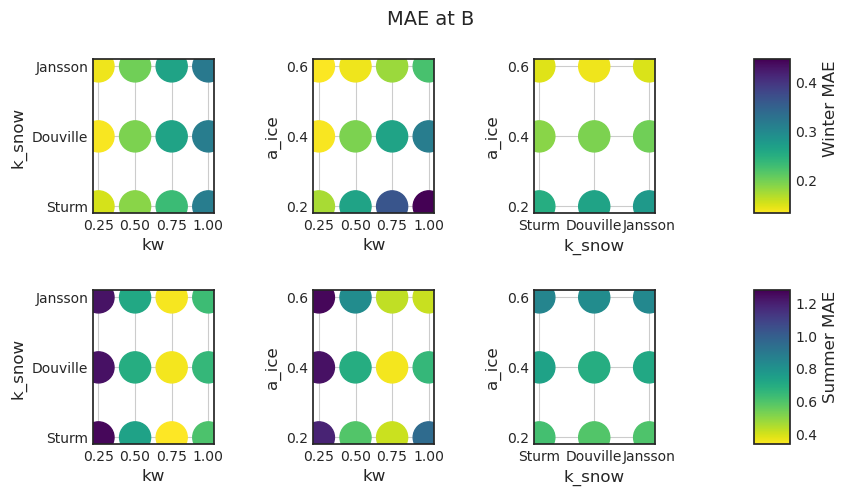

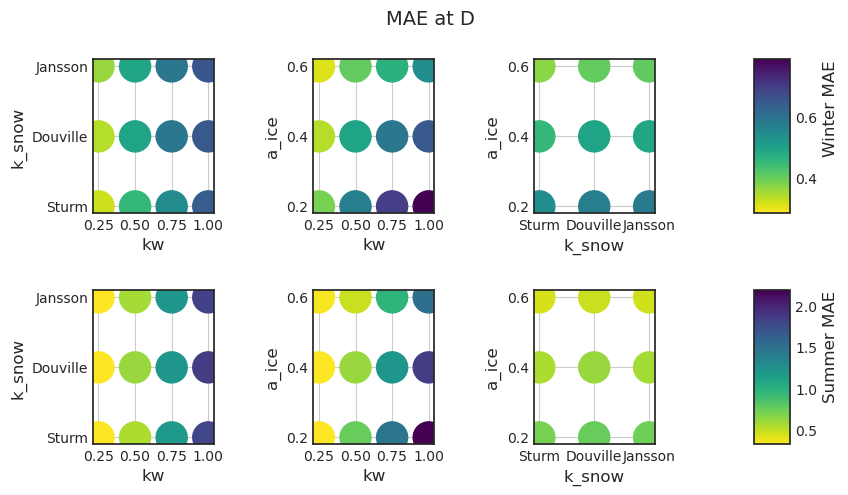

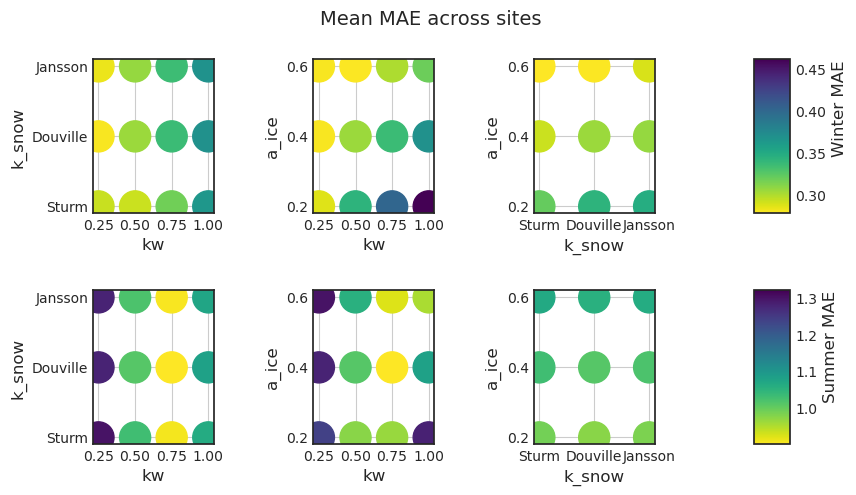

In [243]:
for site in ['AB','B','D','mean']:
    idx = np.where(np.array(['AB','B','D','mean']) == site)[0][0]
    fig, axes = grid_plot(params_dict,summer_result[idx],winter_result[idx])
    if site == 'mean':
        title_first = f'Mean MAE across sites'
    else:
        title_first = f'MAE at {site}'
    if summer_result.shape == (4,4,3,3):
        fig.suptitle(title_first,fontsize=14)
        plt.savefig(f'/home/claire/research/Output/Figs/grid_plot_{site}.png',dpi=200,bbox_inches='tight')
    elif summer_result.shape == (4,3,3):
        fig.suptitle(f'{title_first}\nWith kw=0.25 at D and 1 elsewhere',fontsize=14)
        plt.savefig(f'/home/claire/research/Output/Figs/grid_plot_{site}_nokw.png',dpi=200,bbox_inches='tight')

Must index dates exactly 1 year - 1 day apart
0.8826196077192149


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Summer accumulation and winter ablation at site B'}, ylabel='Partitioned seasonal mass balance (m w.e.)'>)

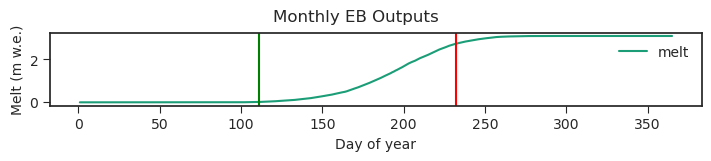

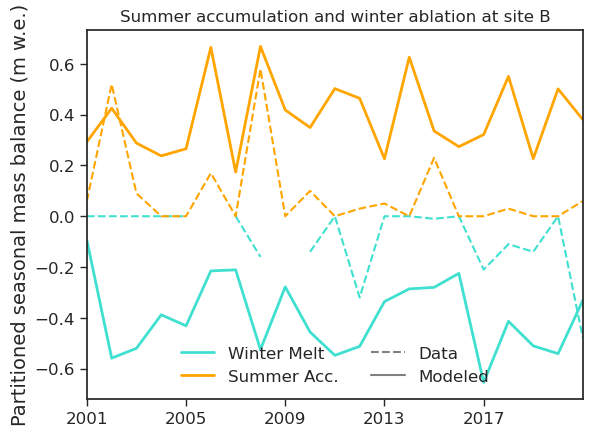

In [16]:
plot_by(ds,[startdate,'2022-04-20'],[['melt']],by='doy')
seasonal_mass_balance(data_fp,ds,'B',plot='w-s+')

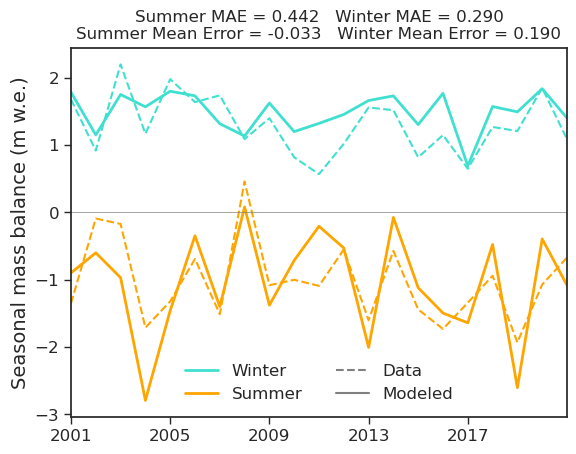

In [30]:
# ds = xr.open_dataset('/home/claire/research/Output/calibration/09_23/kw0.25_ksnowDouville_aice0.4_siteD_0.nc')
ds = xr.open_dataset('/home/claire/research/Output/calibration/10_01/kw_calibration_10_01_run39_0.nc')

# ds.melt.values *= 1000
# plot_by(ds,[startdate,'2022-04-20'],[['melt']],by='doy')
fig,ax = seasonal_mass_balance(data_fp,ds,'D',plot=True)
plt.show()